In [163]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import itertools
import pandas as pd
from scipy.stats import binom
import xgboost
import lightgbm
import catboost
from xgboost import XGBRFClassifier

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import f1_score, accuracy_score

In [96]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

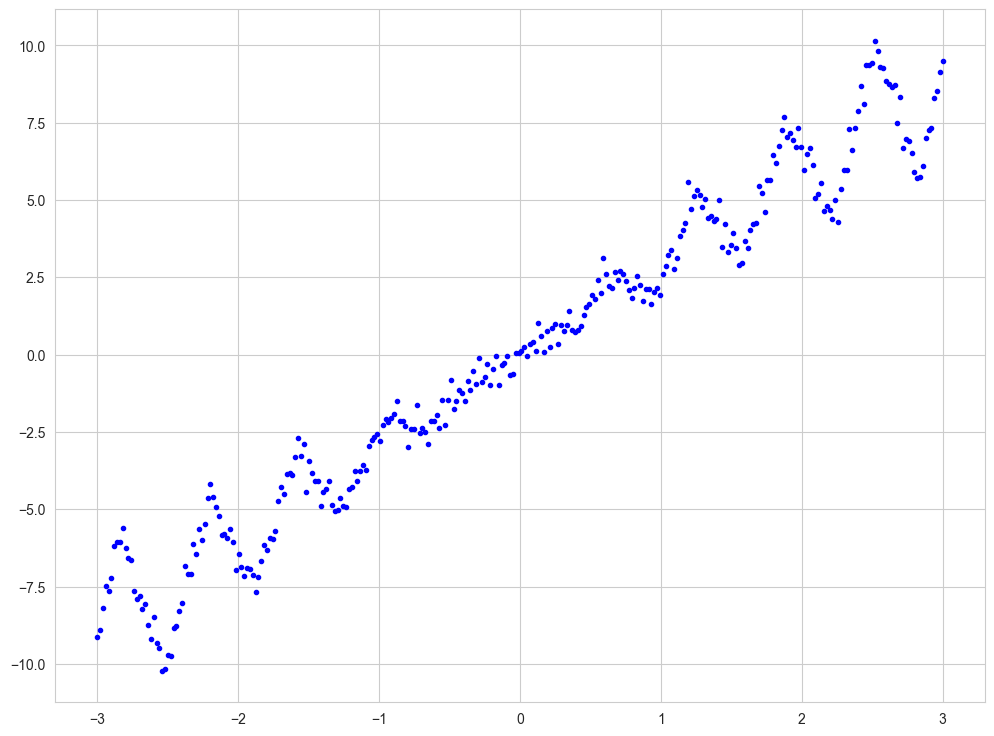

In [97]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [98]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    # plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [99]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

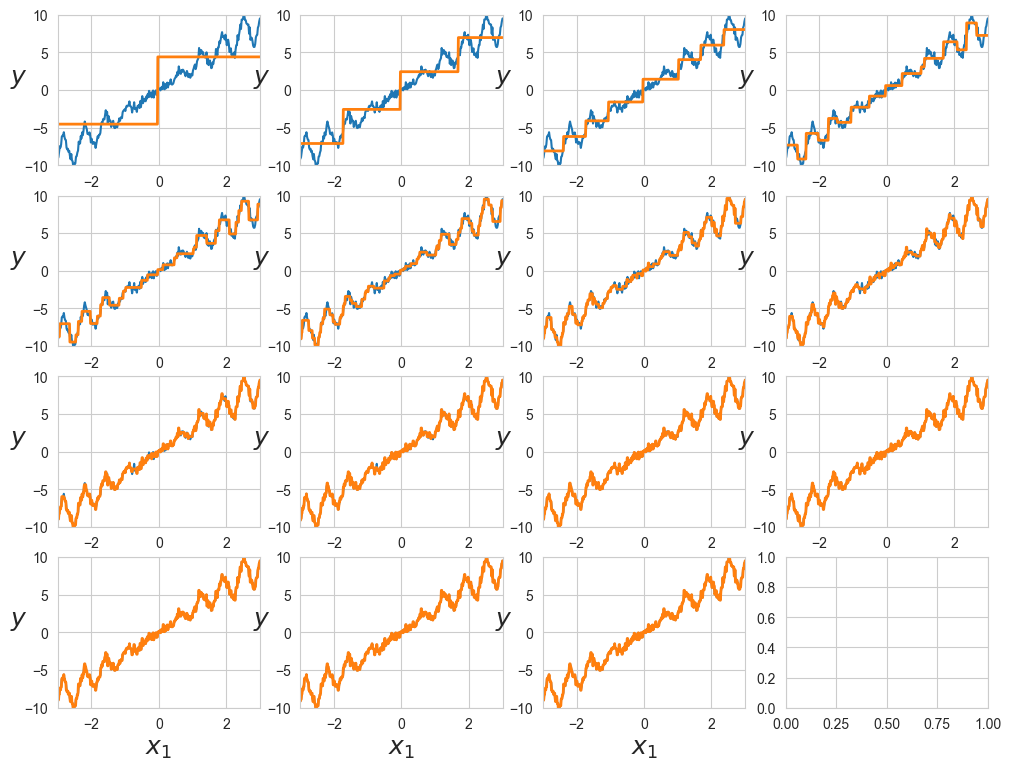

In [100]:
plt.subplots(4, 4)
for i in range(1, 16):
    plt.subplot(4, 4, i)
    plt.plot(X.reshape(-1), y.reshape(-1))
    my_tree = DecisionTreeRegressor(max_depth=i)
    my_tree.fit(X, y)
    plot_regression_predictions(tree_reg=my_tree, X=X, y=y, axes=[-3, 3, -10, 10], ylabel="$y$")

Так, ну тут начиная где-то с 8 предсказания по сути совпадают полностью с моделью6 что и логично - дерево просто все выучило:))

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [101]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [102]:
# функция, чтобы считать полную вероятность верного предсказания при вероятности p
def calculate_full_prob(p, n):
    return sum([binom.pmf(i, n, p) for i in range(n//2 + 1, n+1)])

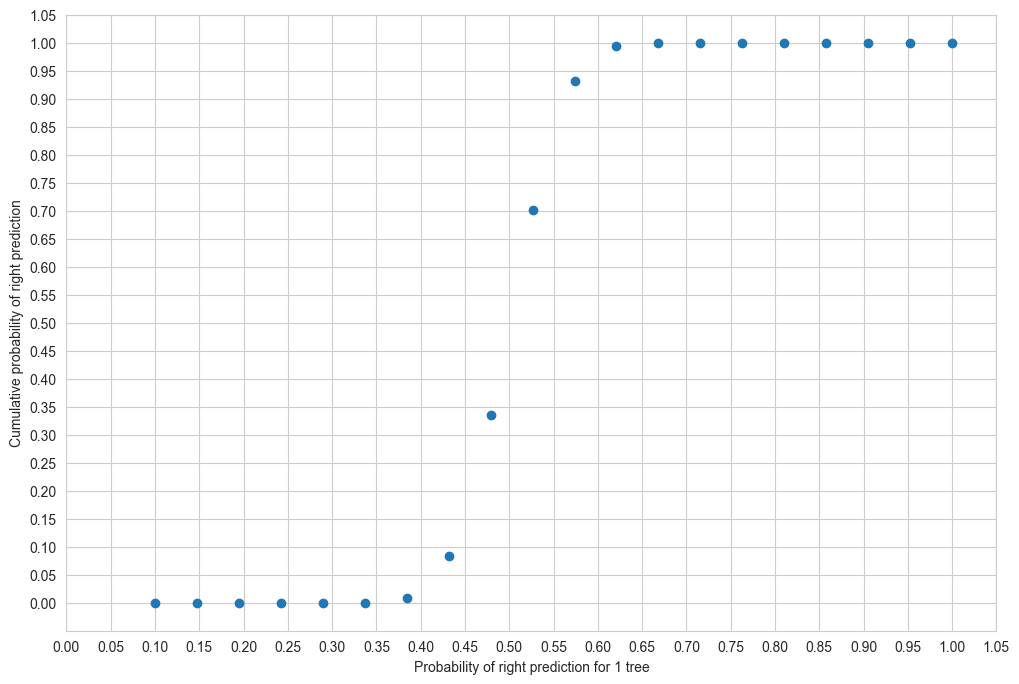

In [103]:
probs = np.linspace(0.1, 1, 20)
plt.figure(figsize=(12,8))
plt.scatter(probs, calculate_full_prob(probs, n=101))
plt.xticks(np.arange(0, 1.1, step=0.05))
plt.yticks(np.arange(0, 1.1, step=0.05))
plt.xlabel('Probability of right prediction for 1 tree')
plt.ylabel('Cumulative probability of right prediction');

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [104]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

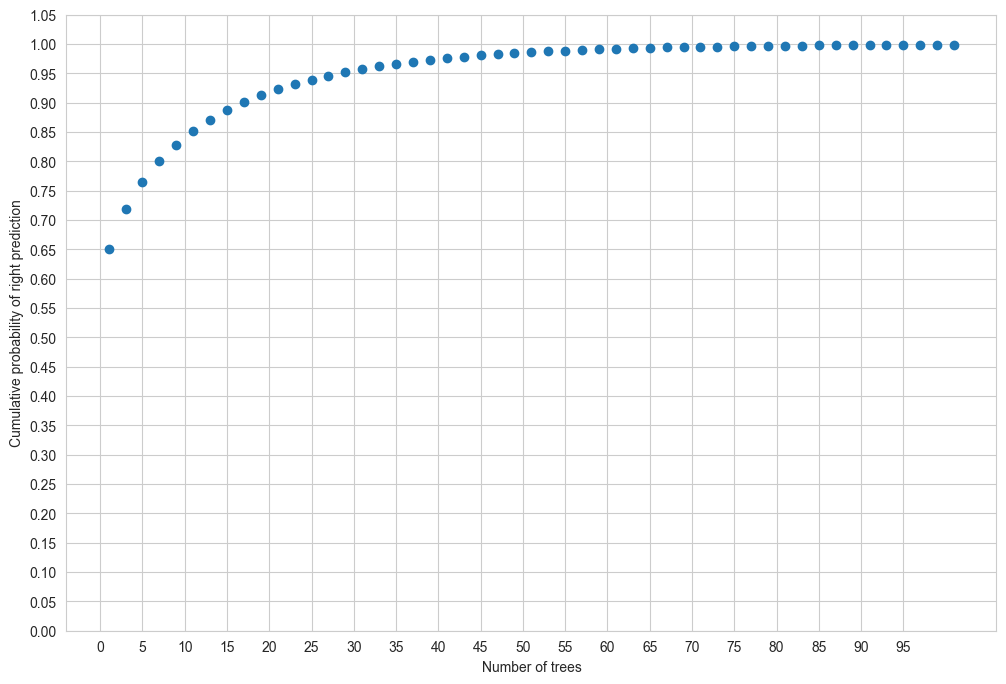

In [105]:
num_of_trees = np.arange(1, 102, 2)
plt.figure(figsize=(12,8))
probs = [calculate_full_prob(p=0.65, n=i) for i in num_of_trees]
plt.scatter(num_of_trees, probs)
plt.xticks(np.arange(0, 100, step=5))
plt.yticks(np.arange(0, 1.1, step=0.05))
plt.xlabel('Number of trees')
plt.ylabel('Cumulative probability of right prediction');

Опишите ваши наблюдения:

* Если каждое дерево предсказывает с вероятностью ниже 0.5, то очевидно лучше не использовать ансамбль из них
* При вероятности от 0.65 для одного дерева вероятность предсказания ансамблем из 101 дерева практически 1.
* Если поварьировать количество деревьев в ансамбле, выбрав лучшую вероятность 0.65, то получается что при 30 деревья вероятность правильного предсказания больше 95 %, а при 65 - 1. Здесь я брала только нечетное количество деревьев, иначе не понятно, что такое большинство и график немонотонный получается для чет/нечет

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [106]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            if self.max_features is None or self.max_features > n_features:
                self.max_features = n_features
            feat_ids = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            
            sample_indices = np.random.choice(n_samples, n_samples, replace=True)
            bootstrap_X = X[sample_indices][:, feat_ids]
            bootstrap_y = y[sample_indices]
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)
         
        return self
            

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        probas = np.zeros((X.shape[0], len(self.classes_)))

        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            probas += tree.predict_proba(X[:, feat_ids])

        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [107]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

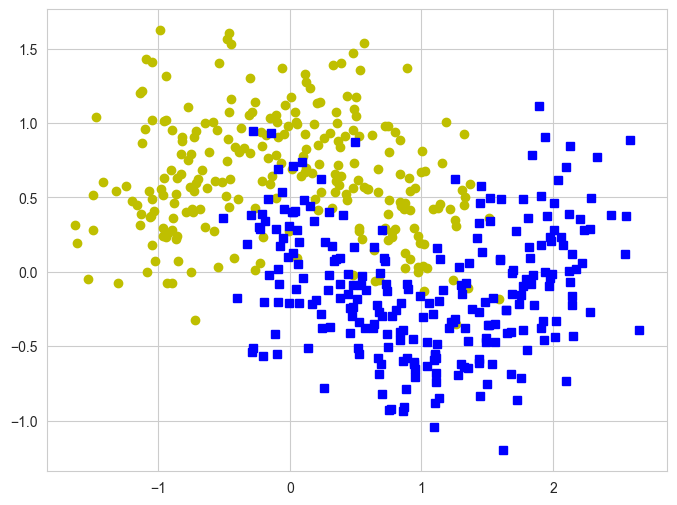

In [108]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [109]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

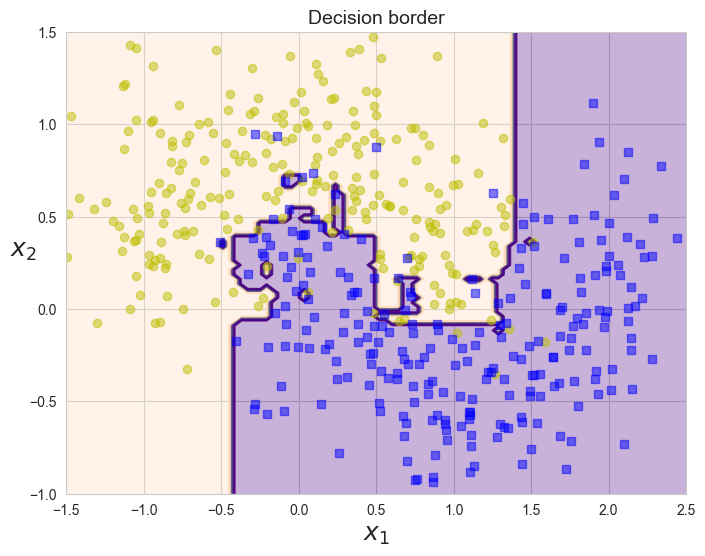

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(max_depth=20, max_features = 2, random_state=SEED)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Попробуем grid searchCV. Жесть, не работает....

In [111]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [112]:
parameters = {'max_depth': {2, 5, 10, 15},
              'max_features': {1, 5, 10, 15},
              'n_estimators': {5, 10, 20}}
param_combinations = list(itertools.product(*parameters.values()))

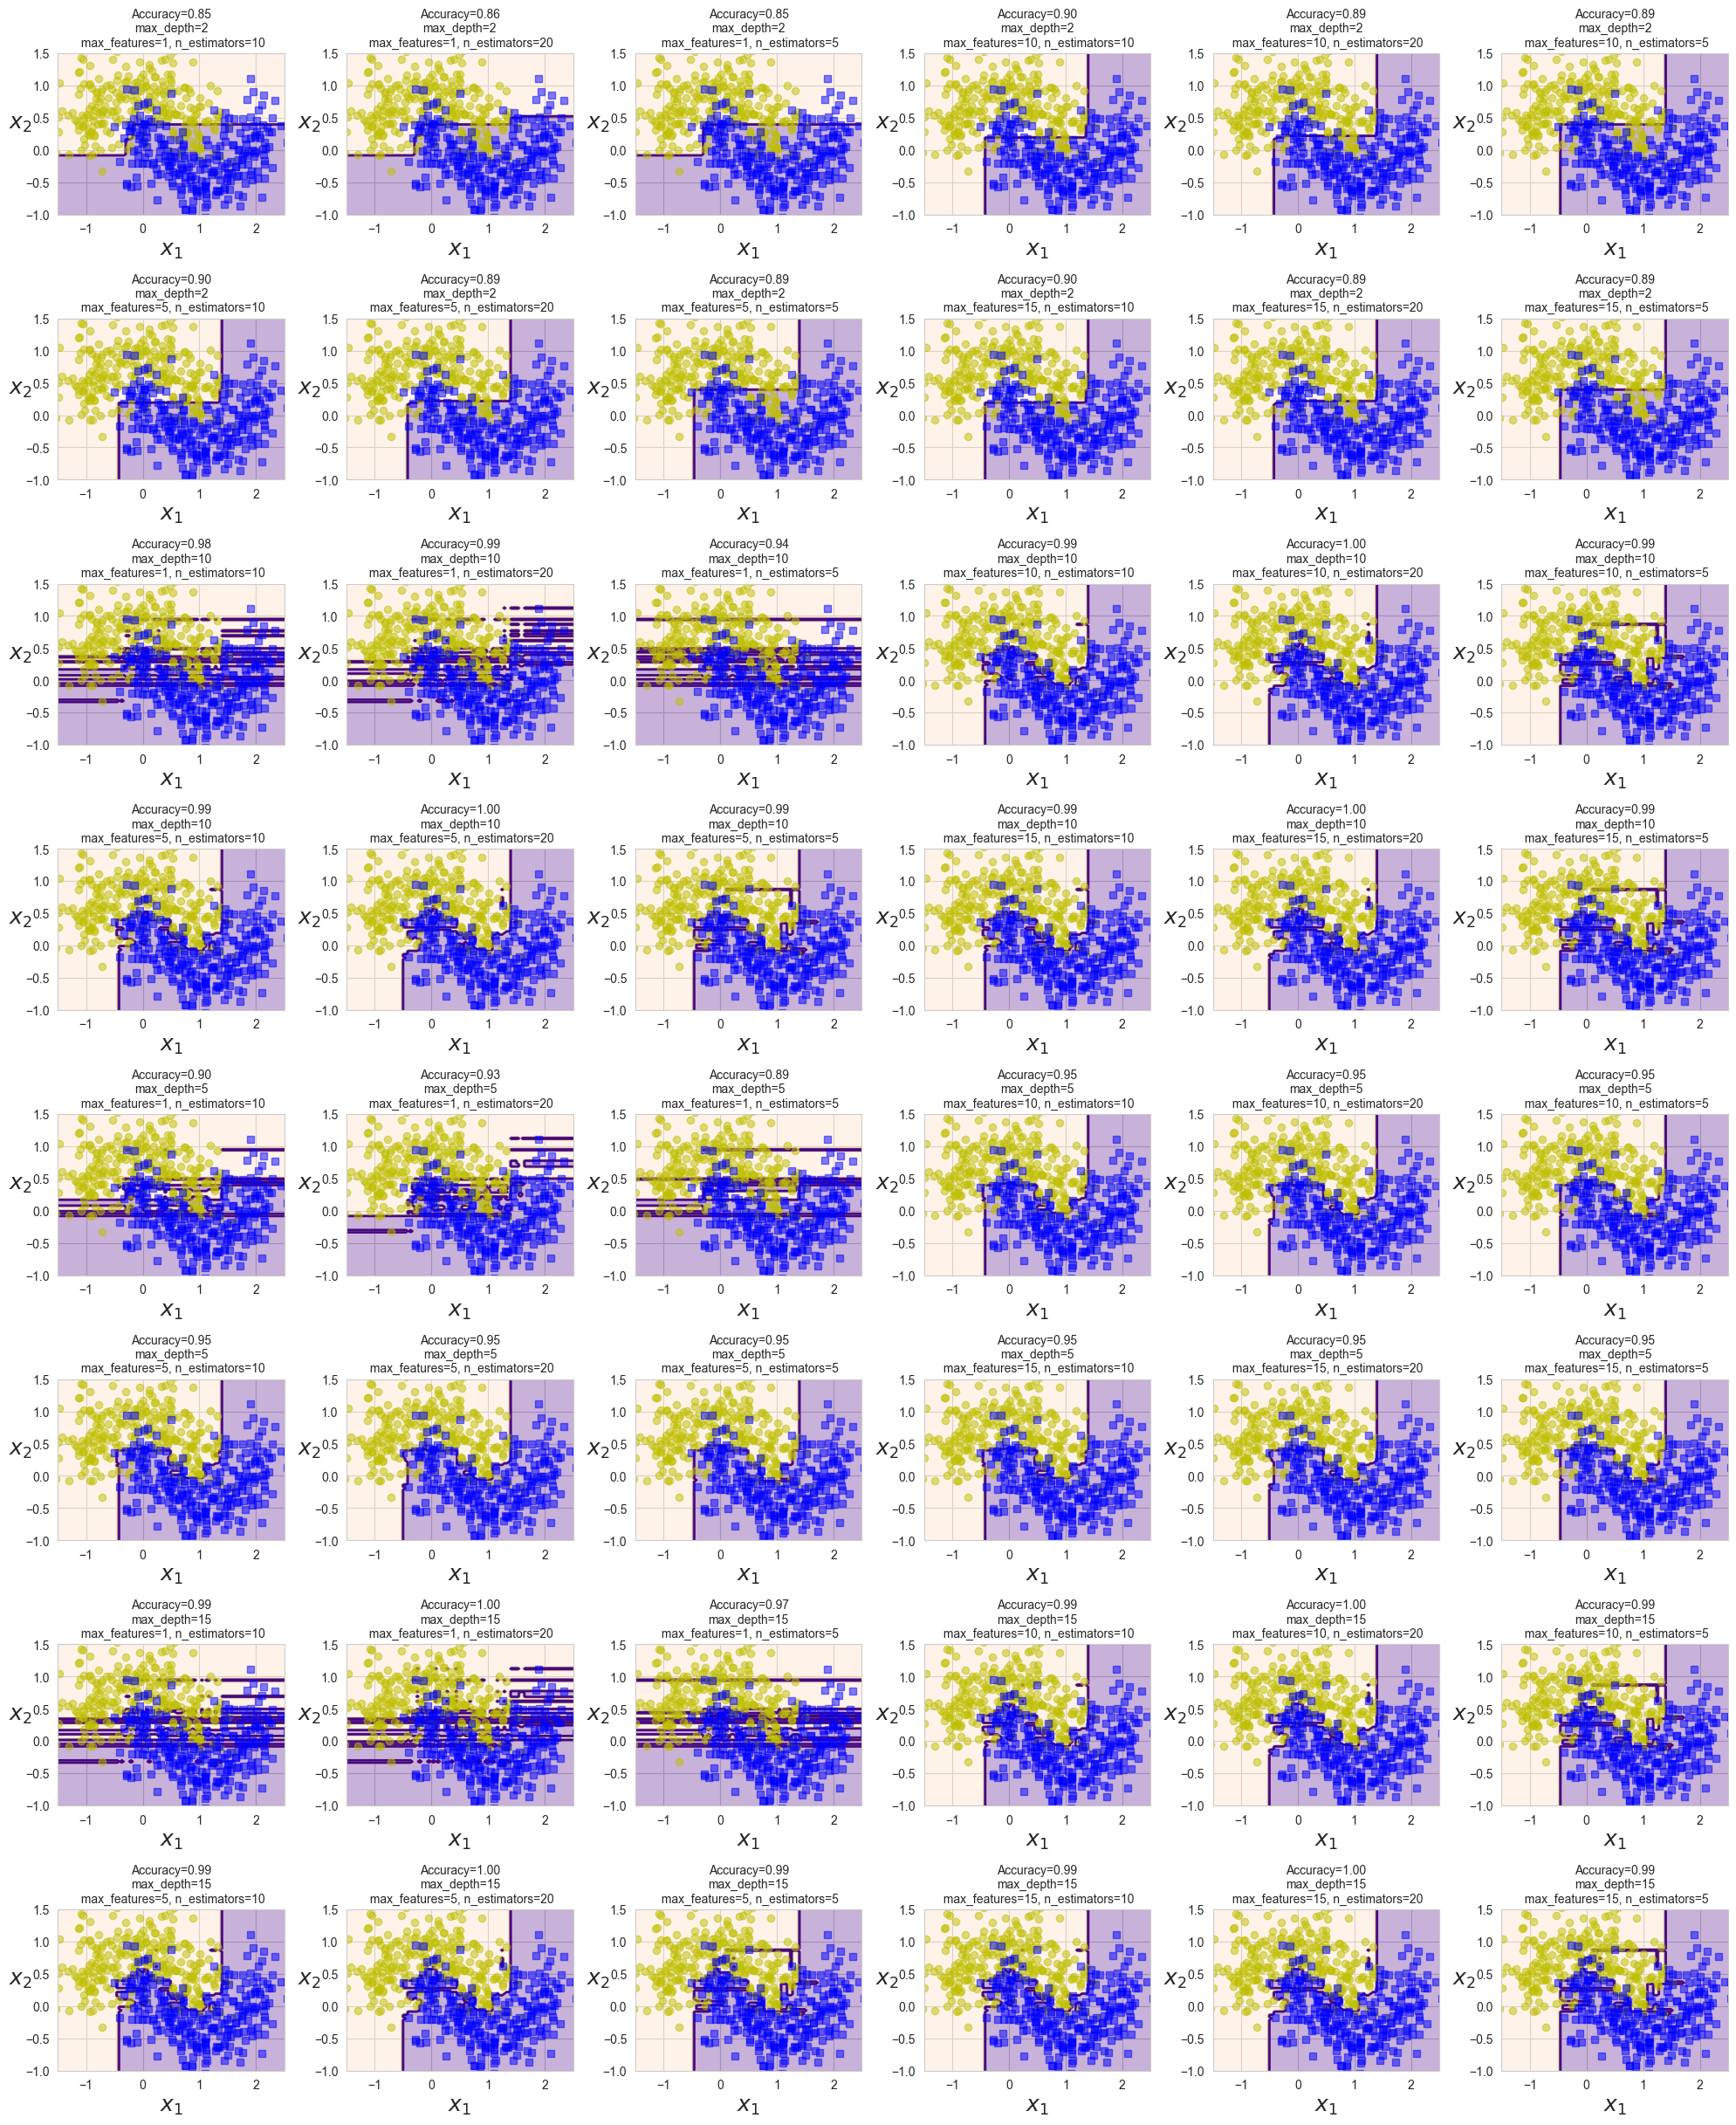

In [113]:
plt.figure(figsize=(20, 30))

for i, params in enumerate(param_combinations, 1):
    clf = RandomForestClassifierCustom(max_depth=params[0], max_features=params[1], n_estimators=params[2], random_state=SEED)
    clf.fit(X, y)
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)
    
    plt.subplot(10, 6, i)
    plot_decision_boundary(clf, X, y)
    plt.title(f"Accuracy={accuracy:.2f}\nmax_depth={params[0]}\n max_features={params[1]}, n_estimators={params[2]}", fontsize=10)

plt.tight_layout()
plt.show()

Наиболее оптимальным кажется разделение при max_depth=5, при этом другие характеристики как будто сильно не влияют на результат.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выяснили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [114]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [115]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [116]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [117]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
corrs = base_model_pair_correlation(clf, X_test)
print(f'Mean correlation={corrs.mean()}')

Mean correlation=0.8074315137964473


Средняя корреляция очень высокая - оно и понятно, раз мы использовали по дефолту все признаки для каждого дерева.

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [118]:
num_features = X.shape[1]
corr_results = []

for i in range(1, num_features+1):
    clf = RandomForestClassifier(n_estimators=10, max_features=i, random_state=42)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X_test)
    corr_results.append(corr)

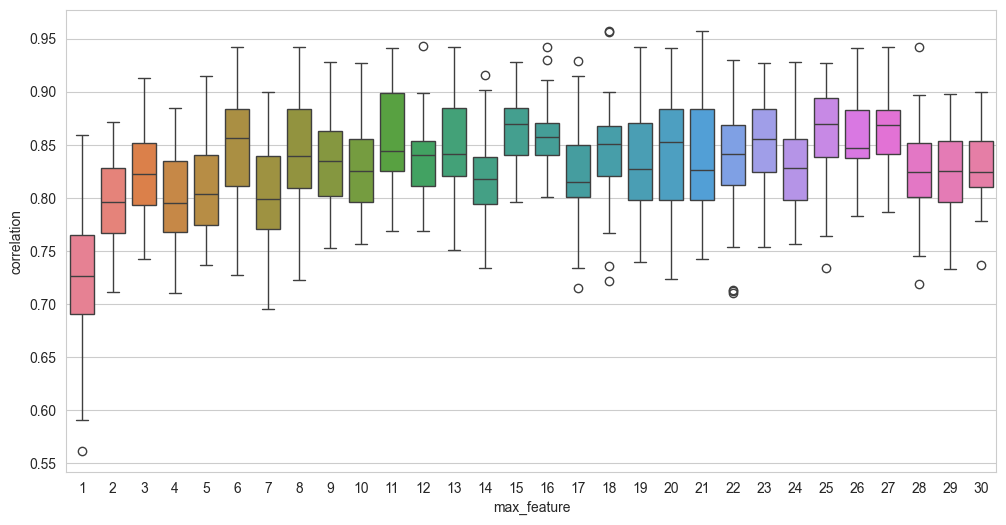

In [119]:
plt.figure(figsize=(12, 6))
sns.boxplot(corr_results)
plt.xlabel('max_feature')
plt.ylabel('correlation')
plt.xticks(np.arange(0, 30, step=1), labels=np.arange(1, 31, step=1))
plt.show()

Опишите ваши наблюдения:

* Что-то я ожидала большего. В целом с увеличением max features корреляция должна возрастать, она и возрастает, но я думала будет сильно более выраженный рост + тут большой разброс достаточно

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [120]:
heart_dataset = pd.read_csv("../data/raw_data/heart.csv")

In [121]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [122]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [123]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
soft_clf = VotingClassifier(estimators=base_models, voting="soft")
hard_clf = VotingClassifier(estimators=base_models, voting="hard")


## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, hard_clf, soft_clf]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
VotingClassifier (hard): 0.8445754787218203
VotingClassifier (soft): 0.8503633581946834

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [124]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [125]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
hard_clf = VotingClassifier(estimators=base_models, voting='hard')
hard_clf.fit(X_train, y_train)
corr_hard = base_model_pair_correlation_for_voting_clf(hard_clf, X_test)

soft_clf = VotingClassifier(estimators=base_models, voting='soft')
soft_clf.fit(X_train, y_train)
corr_soft = base_model_pair_correlation_for_voting_clf(soft_clf, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Далее я пытаюсь полученные данные привести в читабельный вид

In [126]:
df_corr_hard = pd.DataFrame(corr_hard, columns=['Model_1', 'Model_2', 'Correlation'])
df_corr_hard[['Model_1', 'Model_2']] = df_corr_hard[['Model_1', 'Model_2']].astype(str)
models_short_names = ['DT', 'RF', 'ETC', 'KNN', 'SVC_LIN', 'SVC_RBF', 'CAT', 'LGBM', 'LGBM_RF', 'XGB', 'XGB_RF', 'LR', 'NB']

for idx, model in enumerate(df_corr_hard['Model_1'].unique()):
    df_corr_hard.replace(model, models_short_names[idx], inplace=True)

df_corr_mirror = df_corr_hard[['Model_2', 'Model_1', 'Correlation']].rename(columns={'Model_2': 'Model_1', 'Model_1': 'Model_2'})
df_final_hard_corr = pd.concat([df_corr_hard, df_corr_mirror], ignore_index=True)
df_final_hard_corr

,Model_1,Model_2,Correlation
0,DT,RF,0.813489
1,DT,ETC,0.777190
2,DT,KNN,0.313329
3,DT,SVC_LIN,0.715376
4,DT,SVC_RBF,0.282047
...,...,...,...
151,LR,XGB,0.800997
152,GaussianNB(),XGB,0.713940
153,LR,XGB_RF,0.821946
154,GaussianNB(),XGB_RF,0.743131


In [127]:
df_corr_soft = pd.DataFrame(corr_soft, columns=['Model_1', 'Model_2', 'Correlation'])
df_corr_soft[['Model_1', 'Model_2']] = df_corr_soft[['Model_1', 'Model_2']].astype(str)

for idx, model in enumerate(df_corr_soft['Model_1'].unique()):
    df_corr_soft.replace(model, models_short_names[idx], inplace=True)

df_corr_mirror = df_corr_soft[['Model_2', 'Model_1', 'Correlation']].rename(columns={'Model_2': 'Model_1', 'Model_1': 'Model_2'})
df_final_soft_corr = pd.concat([df_corr_soft, df_corr_mirror], ignore_index=True)
df_final_soft_corr

,Model_1,Model_2,Correlation
0,DT,RF,0.813489
1,DT,ETC,0.777190
2,DT,KNN,0.313329
3,DT,SVC_LIN,0.715376
4,DT,SVC_RBF,0.282047
...,...,...,...
151,LR,XGB,0.800997
152,GaussianNB(),XGB,0.713940
153,LR,XGB_RF,0.821946
154,GaussianNB(),XGB_RF,0.743131


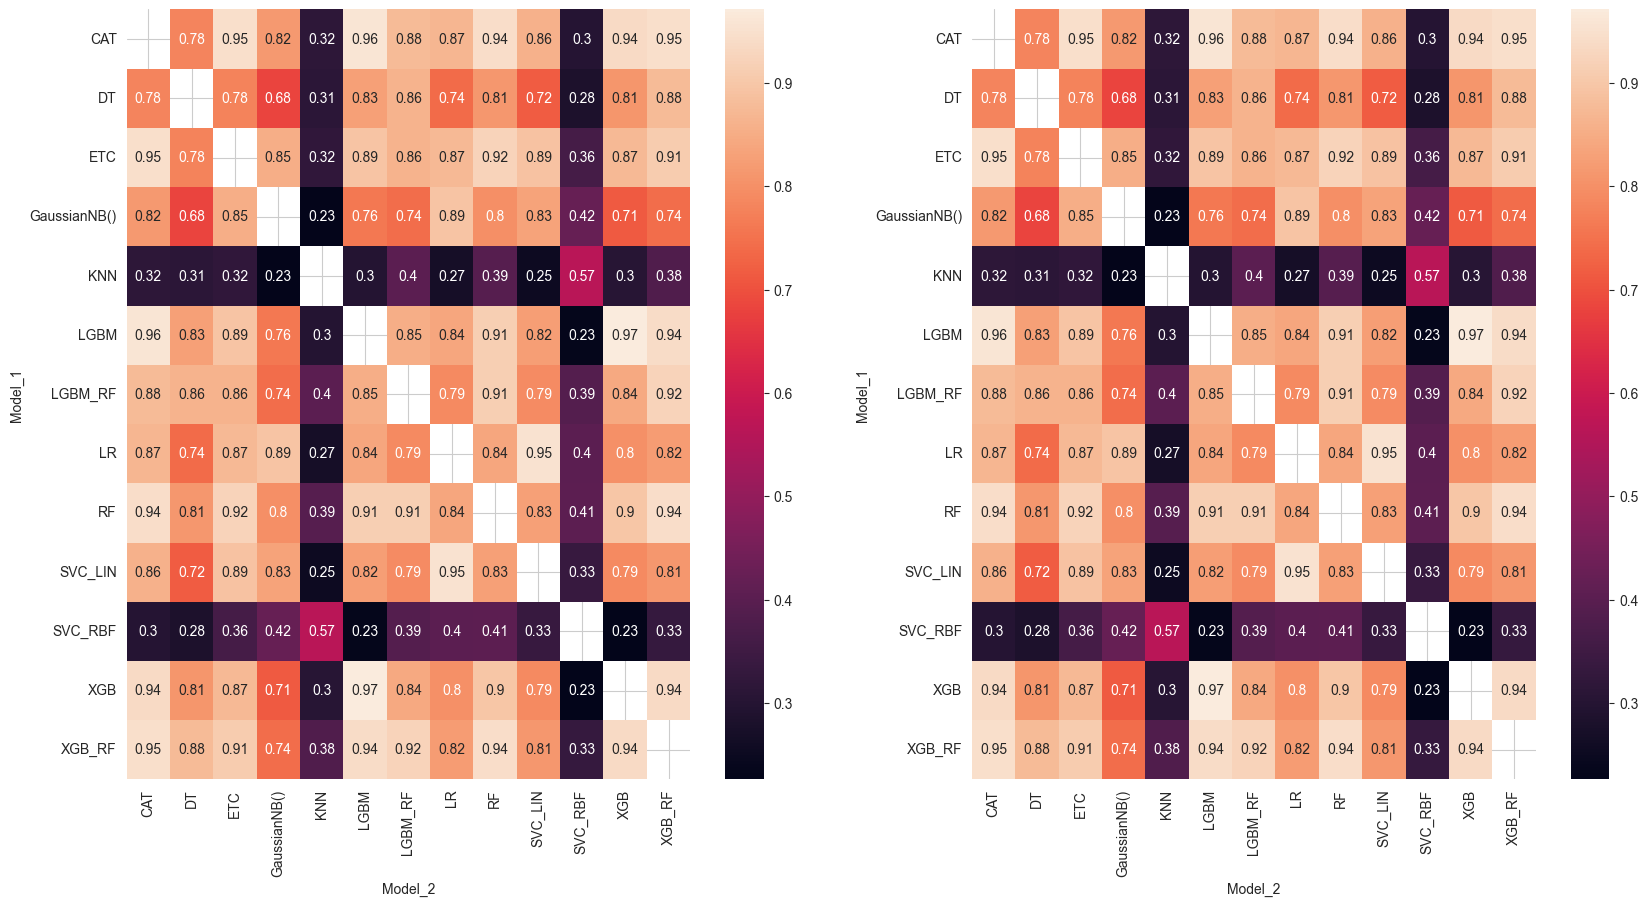

In [128]:
corr_matrix_hard = df_final_hard_corr.pivot(index='Model_1', columns='Model_2', values='Correlation')
corr_matrix_soft = df_final_soft_corr.pivot(index='Model_1', columns='Model_2', values='Correlation')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_hard, annot=True)
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_soft, annot=True)
plt.show()

In [129]:
base_models = [("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("LGBM", lgbm), ("XGB", xgb), 
               ("LR", lr)]

## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
soft_clf = VotingClassifier(estimators=base_models, voting="soft")
hard_clf = VotingClassifier(estimators=base_models, voting="hard")

## END YOUR CODE HERE ##

for model in [hard_clf, soft_clf]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

Hard VotingClassifier: 0.8379629629629629
Soft VotingClassifier: 0.8622426432752786

Я попыталась поперебирать разные модели, но в итоге просто перебрала за 3 часа все возможные комбинации на сервере, и вот финальная табличка со скорами:

In [130]:
results = pd.read_csv('../data/processed_data/results.csv')
results

,Unnamed: 0,Combination,VotingType,F1Score
0,2123,DT+SVC_LIN+LGBM+XGB+LR,hard,0.874724
1,2947,KNN+SVC_LIN+LGBM_RF+XGB+LR,hard,0.871928
2,2217,DT+LGBM_RF+XGB+LR+NB,hard,0.870451
3,5803,DT+KNN+SVC_LIN+LGBM+XGB+XGB_RF+LR,hard,0.869963
4,1979,DT+KNN+SVC_LIN+SVC_RBF+LR,hard,0.869870
...,...,...,...,...
8161,67,KNN+LGBM_RF,hard,0.679072
8162,62,KNN+SVC_RBF,soft,0.677517
8163,75,KNN+NB,hard,0.669394
8164,5,DT+KNN,hard,0.652287


Таким образом, нам например, подходит следующая модель: DT, SVC_LIN, LGBM, XGB, LR.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [142]:
data = pd.read_csv("../data/raw_data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

Совсем нет пропусков, гуд. Переименуем некоторые названия колонок:

In [144]:
data=data.rename(columns={'Churn?': 'Churn'})
data=data.rename(columns={"Int'l Plan": "Intl Plan"})
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Intl Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn'],
      dtype='object')

Теперь удалим очевидно бесполезные данные: код региона, номер телефона, и State. А еще переделаем колонку Churn и сопоставим каждому False - 0, а True - 1. Аналогично для колонок Intl Plan, VMail Plan, yes - 1, no - 0.


In [145]:
data_dropped = data.drop(['State','Area Code','Phone'],axis=1)
data_dropped['Churn']=data_dropped['Churn'].apply(lambda x:1 if x=="True." else 0 )
data_dropped['Intl Plan']=data_dropped['Intl Plan'].apply(lambda x:1 if x=="yes" else 0 )
data_dropped['VMail Plan']=data_dropped['VMail Plan'].apply(lambda x:1 if x=="yes" else 0 )
data_dropped.head(3)

,Account Length,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0


In [146]:
X = data_dropped.drop(['Churn'], axis=1)
y = data_dropped['Churn']

Посмотрим на распределения разные:

In [147]:
for col in X.columns:
    print(f'Unique values in {col}: {X[col].unique().shape[0]}')

Unique values in Account Length: 212
Unique values in Intl Plan: 2
Unique values in VMail Plan: 2
Unique values in VMail Message: 46
Unique values in Day Mins: 1667
Unique values in Day Calls: 119
Unique values in Day Charge: 1667
Unique values in Eve Mins: 1611
Unique values in Eve Calls: 123
Unique values in Eve Charge: 1440
Unique values in Night Mins: 1591
Unique values in Night Calls: 120
Unique values in Night Charge: 933
Unique values in Intl Mins: 162
Unique values in Intl Calls: 21
Unique values in Intl Charge: 162
Unique values in CustServ Calls: 10


Получается, у нас есть следующие категориальные переменные: Intl Plan, VMail Plan. Остальные колонки с немногочисленными unique values судя по описанию датасета все же больше похожи на "непрерывные", это количество звонков в день и тд

In [148]:
categorical_cols = ['Intl Plan', 'VMail Plan']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

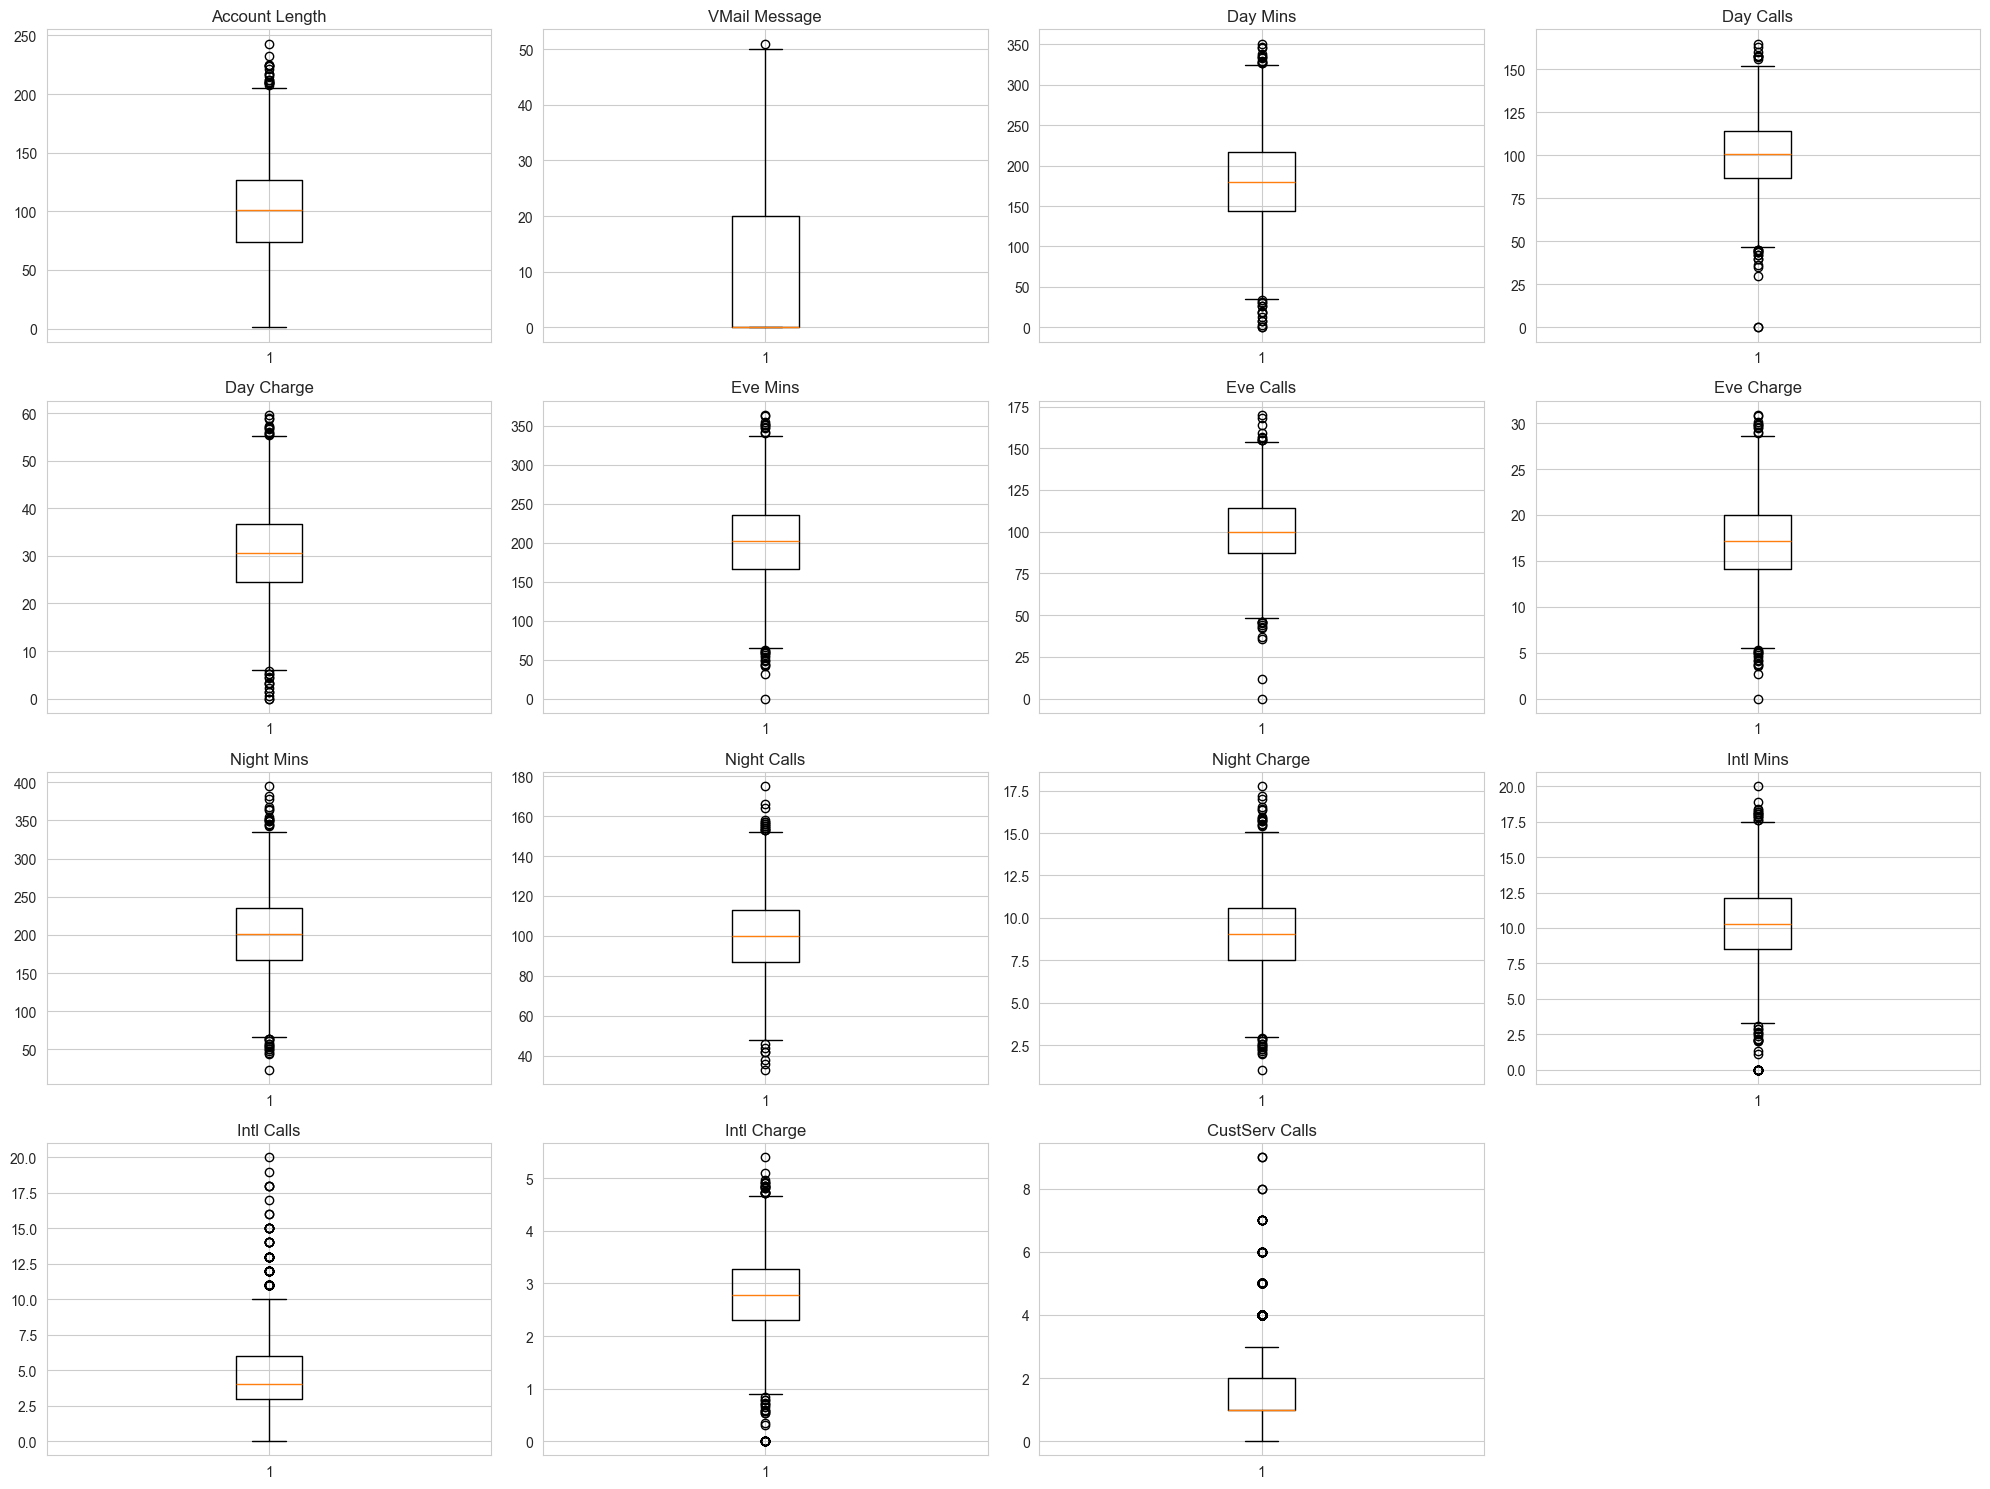

In [149]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    plt.boxplot(X[col])
    plt.title(col)
    
plt.tight_layout()
plt.show()

Мне не кажется что-то из этого прям выбросами-выбросами, ну есть какие-то большие значения, но даже по смыслу датасета это не то чтобы что-то странное - разные пользователи разное количество звонков могут совершать.

Посмотрим на распределение по Churn:

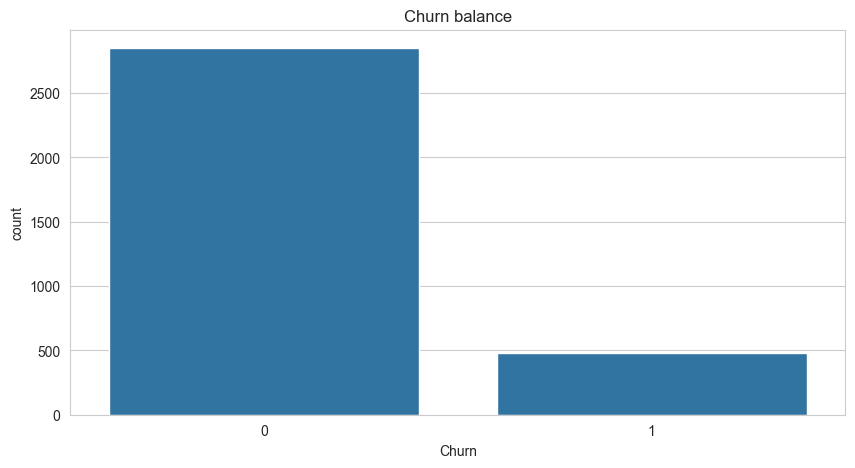

In [150]:
plt.figure(figsize=(10, 5))
plt.title('Churn balance')
sns.countplot(data_dropped, x='Churn');

Хе-Хе, у нас прям мало данных для пользователей, которые ушли. Посмотрим на корреляцию между фичами, может можно еще что-то выкинуть:

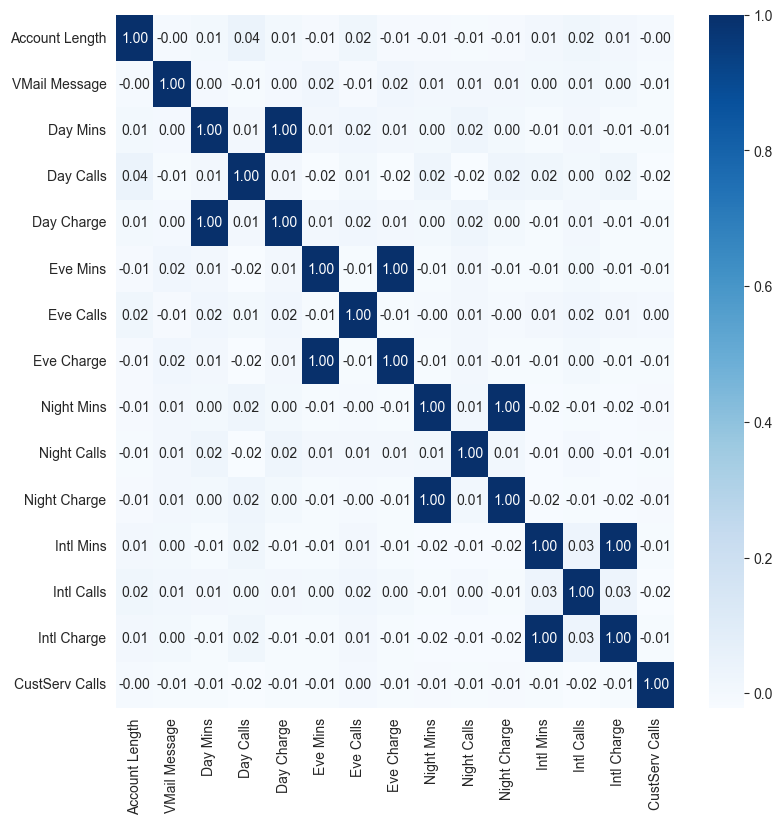

In [151]:
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(9, 9))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt=".2f")
plt.show()

Есть очень сильная корреляция между некоторыми фичами:

Day Mins + Day Charge, Eve Mins + Eve Charge, Night Mins + Night Charge, Intl Mins + Intl Charge. 

Судя по описанию датасета, первое - это суммарное количество минут, а второе – суммарная цена. Поэтому и 100% корреляция. Удалим Charge.

In [152]:
data_dropped2 = data_dropped.drop(['Day Charge','Eve Charge', 'Night Charge', 'Intl Charge'],axis=1)
data_dropped2

,Account Length,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0


In [153]:
X = data_dropped2.drop(['Churn'], axis=1)
y = data_dropped2['Churn']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = SEED)

In [155]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import xgboost as xgb

In [156]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 200,
        'seed': 0
    }

In [157]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK }

In [158]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [00:43<00:00,  2.31trial/s, best loss: -0.8551422845691382]


In [159]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9354374931887892, 'gamma': 4.296260794137641, 'max_depth': 17.0, 'min_child_weight': 6.0, 'reg_alpha': 58.0, 'reg_lambda': 0.7819277439699369}


In [161]:
best_params = {'colsample_bytree': 0.9354374931887892, 'gamma': 4.296260794137641, 'max_depth': 17, 'min_child_weight': 6.0, 'reg_alpha': 58.0, 'reg_lambda': 0.7819277439699369}
clf_best = xgb.XGBClassifier(**best_params)
clf_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9354374931887892, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.296260794137641,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=6.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [162]:
y_pred = clf_best.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print(f'Accuracy = {ac}')

Accuracy = 0.854916067146283


In [173]:
space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': 200,
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 10),
    'seed': 0,
}

In [174]:
def objective(space):
    clf=XGBRFClassifier(
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        gamma=space['gamma'],
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        colsample_bynode=space['colsample_bynode'],
        reg_lambda=space['reg_lambda'])
    
    score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK }

In [175]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [01:34<00:00,  1.06trial/s, best loss: -0.8550859705282494]


In [177]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bynode': 0.9288438164872868, 'colsample_bytree': 0.5865183641258807, 'gamma': 0.4448192048070106, 'learning_rate': 0.0975170159226465, 'max_depth': 4, 'min_child_weight': 2, 'reg_lambda': 8.213078252514736, 'subsample': 0.8733130764089404}


In [178]:
best_params = {'colsample_bynode': 0.9288438164872868, 'colsample_bytree': 0.5865183641258807, 'gamma': 0.4448192048070106, 'learning_rate': 0.0975170159226465, 'max_depth': 4, 'min_child_weight': 2, 'reg_lambda': 8.213078252514736, 'subsample': 0.8733130764089404, 'n_estimators': 200}
clf_best = XGBRFClassifier(**best_params)
clf_best.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=0.9288438164872868,
                colsample_bytree=0.5865183641258807, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0.4448192048070106,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0975170159226465,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=2, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [179]:
y_pred = clf_best.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print(f'Accuracy = {ac}')

Accuracy = 0.854916067146283


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

(︶︹︺)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Это безумно много... Последний пункт тянет на целую домашку